In [1]:
# Import Libraries
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from tqdm import tqdm

In [4]:
# Load CoNLL-2003 Dataset
def load_conll2003_data(file_path):
    sentences, tags = [], []
    sentence, sentence_tags = [], []
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip() == "":
                if sentence:
                    sentences.append(sentence)
                    tags.append(sentence_tags)
                    sentence, sentence_tags = [], []
            else:
                word, _, _, tag = line.split()
                sentence.append(word)
                sentence_tags.append(tag)
    return sentences, tags

train_sentences, train_tags = load_conll2003_data('train_rnn.txt')
test_sentences, test_tags = load_conll2003_data('test_rnn.txt')

In [5]:
# Preprocess Data
def build_vocab(data):
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for sentence in data:
        for word in sentence:
            if word not in vocab:
                vocab[word] = len(vocab)
    return vocab

word_vocab = build_vocab(train_sentences)
tag_vocab = build_vocab(train_tags)
tag_reverse_vocab = {v: k for k, v in tag_vocab.items()}

def encode_data(sentences, tags, word_vocab, tag_vocab, max_len=50):
    encoded_sentences, encoded_tags = [], []
    for sent, tag in zip(sentences, tags):
        encoded_sentences.append([word_vocab.get(w, 1) for w in sent][:max_len] + [0] * (max_len - len(sent)))
        encoded_tags.append([tag_vocab[t] for t in tag][:max_len] + [0] * (max_len - len(tag)))
    return np.array(encoded_sentences), np.array(encoded_tags)

train_inputs, train_labels = encode_data(train_sentences, train_tags, word_vocab, tag_vocab)
test_inputs, test_labels = encode_data(test_sentences, test_tags, word_vocab, tag_vocab)

In [6]:
# Step 4: Define Dataset and DataLoader
class NERDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.labels[idx])

train_dataset = NERDataset(train_inputs, train_labels)
test_dataset = NERDataset(test_inputs, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define RNN Model
class NERModel(nn.Module):
    def __init__(self, vocab_size, tag_size, embedding_dim, hidden_dim):
        super(NERModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tag_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

vocab_size = len(word_vocab)
tag_size = len(tag_vocab)
model = NERModel(vocab_size, tag_size, embedding_dim=100, hidden_dim=128)

# Train the Model
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

def train_model(model, data_loader, criterion, optimizer, num_epochs=10):
    ls_total_loss = []
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in tqdm(data_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            ls_total_loss.append(loss)
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(data_loader)}")

    return ls_total_loss

ls_total_loss = train_model(model, train_loader, criterion, optimizer)

100%|██████████| 469/469 [00:30<00:00, 15.49it/s]


Epoch 1, Loss: 0.2500246420407346


100%|██████████| 469/469 [00:26<00:00, 17.38it/s]


Epoch 2, Loss: 0.11834346242487304


100%|██████████| 469/469 [00:30<00:00, 15.54it/s]


Epoch 3, Loss: 0.07616348906970227


100%|██████████| 469/469 [00:27<00:00, 17.27it/s]


Epoch 4, Loss: 0.05191581035410163


100%|██████████| 469/469 [00:30<00:00, 15.53it/s]


Epoch 5, Loss: 0.036286151469516345


100%|██████████| 469/469 [00:30<00:00, 15.36it/s]


Epoch 6, Loss: 0.025545027821874823


100%|██████████| 469/469 [00:31<00:00, 14.98it/s]


Epoch 7, Loss: 0.01820599081725486


100%|██████████| 469/469 [00:26<00:00, 17.65it/s]


Epoch 8, Loss: 0.012889451892383254


100%|██████████| 469/469 [00:30<00:00, 15.52it/s]


Epoch 9, Loss: 0.009086941726811563


100%|██████████| 469/469 [00:27<00:00, 17.35it/s]

Epoch 10, Loss: 0.0063982628340989766


In [9]:
# plot training loss
import matplotlib.pyplot as plt

# Assuming `ls_total_loss` is a list of batch losses recorded during training
def plot_training_loss(ls_total_loss, batch_size, dataset_size):
    # Calculate the number of batches per epoch
    ls_total_loss = [tl.cpu().item() if isinstance(tl, torch.Tensor) else tl for tl in ls_total_loss]
    batches_per_epoch = dataset_size // batch_size + (dataset_size % batch_size > 0)
    num_epochs = 10

    # Generate x-axis values corresponding to batches
    x_batches = range(1, len(ls_total_loss) + 1)

    # Plot the training loss
    plt.figure(figsize=(10, 6))
    plt.plot(x_batches, ls_total_loss, label="Batch Loss", alpha=0.8)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss over {num_epochs} Epochs")
    plt.axvline(x=batches_per_epoch, color="red", linestyle="--", label="Epoch Boundary")
    plt.legend()
    plt.grid(True)
    plt.show()

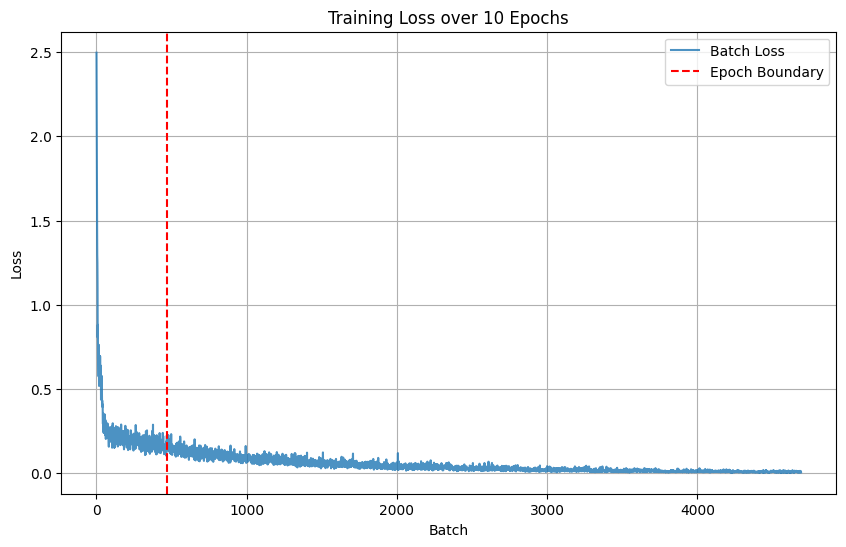

In [10]:
batch_size = 32
dataset_size = len(train_dataset)
plot_training_loss(ls_total_loss, batch_size, dataset_size)

In [11]:
# Evaluate the Model
def evaluate_model(model, data_loader, tag_reverse_vocab):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            preds = outputs.argmax(dim=-1).view(-1).cpu().numpy()
            labels = labels.view(-1).cpu().numpy()
            mask = labels != 0
            all_preds.extend(preds[mask])
            all_labels.extend(labels[mask])

    # Get unique labels from predictions and ground truth
    unique_labels = list(set(all_labels))

    # Filter target names to match unique labels
    target_names = [tag_reverse_vocab[label] for label in unique_labels if label in tag_reverse_vocab]

    #Generate and print classification report
    print(classification_report(all_labels, all_preds, target_names=target_names, labels=unique_labels))

evaluate_model(model, test_loader, tag_reverse_vocab)

              precision    recall  f1-score   support

           O       0.95      0.98      0.97     38378
       B-ORG       0.61      0.57      0.59      1658
      B-MISC       0.73      0.58      0.65       701
       B-PER       0.86      0.49      0.63      1580
       I-PER       0.90      0.47      0.62      1111
       B-LOC       0.75      0.79      0.77      1656
       I-ORG       0.61      0.63      0.62       827
      I-MISC       0.58      0.54      0.56       216
       I-LOC       0.54      0.57      0.55       255

    accuracy                           0.92     46382
   macro avg       0.72      0.63      0.66     46382
weighted avg       0.91      0.92      0.91     46382

